In [2]:
import numpy as np
import random as rd
import tensorflow as tf

from keras.layers import Dense, Embedding, Flatten, Input, concatenate, Dropout,Bidirectional, GRU, merge
from keras.models import Model
from keras.optimizers import Adagrad

#Import another jupyter notebook
import import_ipynb
from Productive_CrossValidation_inclTest import *
from Productive_Data_GetTrainTest import samEval

C:\Users\Anja Tetzner\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


importing Jupyter notebook from Productive_CrossValidation_inclTest.ipynb
importing Jupyter notebook from Productive_TimeHistory.ipynb
importing Jupyter notebook from AttentionLayer.ipynb
importing Jupyter notebook from Productive_Data_GetTrainTest.ipynb


In [3]:
#for reproducability of the results
seed = 7
np.random.seed(seed)
tf.set_random_seed(seed)
rd.seed(seed)

In [4]:
path = 'data/'
outputpath ='outputs/05_afterWu_samEval2018/'

In [5]:
#Load necessary data
train_data, train_labels, test_data, test_labels, word_index, MAX_SEQUENCE_LENGTH = samEval()

In [6]:
#Load pretrained embeddings
import gensim
from gensim.models import KeyedVectors

#Pretrained Google News Embeddings, Dimension 300
GOOGLEEMB = path + 'GoogleNews-vectors-negative300.bin'

embedding= KeyedVectors.load_word2vec_format(GOOGLEEMB, binary=True)

word_vectors = embedding.wv

C:\Users\Anja Tetzner\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\Anja Tetzner\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


In [7]:
#Create embedding-matrix, serves the Keras Embedding Layer as weigths
EMBEDDING_DIM=300

embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector   
    except:
        # words not found in embeddings will be zero
        pass

In [8]:
#Load POS data
def get_pos(file):
    pos =[]
    with open(file, 'r') as f:
        for line in f:
            pos.append([[int(i)] for i in line.split(',')])
    pos= np.asarray(pos)
    return pos

train_pos =get_pos('output_trainTestData/SamEval_train_pos.csv')
test_pos = get_pos('output_trainTestData/SamEval_test_pos.csv')

In [9]:
#Load Sentiment data
def get_sentiment(file):
    senti =[]
    with open(file, 'r') as f:
        for line in f:
            senti.append([[float(i)] for i in line.split(',')])
    senti= np.asarray(senti)
    return senti

train_senti_blob =get_sentiment('output_trainTestData/SamEval_train_data_sentiment_blob.csv')
test_senti_blob = get_sentiment('output_trainTestData/SamEval_test_data_sentiment_blob.csv')

### Hyperparameter for all models

In [10]:
BATCH_SIZE = 64
NUM_EPOCHS = 30
softmax = True
lossfunction ='binary_crossentropy'
optimizer = Adagrad(lr=0.001)

## Wu simple

In [28]:
#Word Embeddings
wv_layer = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix],
                 input_length=MAX_SEQUENCE_LENGTH,
                 mask_zero = True) #trainable raus

input_embedding = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedded_sequences = wv_layer(input_embedding)
x_embedding = Dropout(0.2)(embedded_sequences)

#Sentiment Features
input_sentiment = Input(shape=(MAX_SEQUENCE_LENGTH,1), dtype='float')

#POS Features
input_pos = Input(shape=(MAX_SEQUENCE_LENGTH,1), dtype='float')

#Concatination
merge_input=concatenate([x_embedding,input_sentiment,input_pos], axis=-1)

#BiGRU
gru_1 = Bidirectional(GRU(300,return_sequences=True,dropout=0.2,recurrent_dropout=0.2))(merge_input)
gru_2 = Bidirectional(GRU(300,return_sequences=True,dropout=0.2,recurrent_dropout=0.2))(gru_1)

#Concatenation
concat = concatenate([gru_1, gru_2])

#BiGRU
gru_3 = Bidirectional(GRU(300,return_sequences=False,dropout=0.4,recurrent_dropout=0.4))(concat)

x = Dense(200,activation='relu')(gru_3)
preds = Dense(2,activation='softmax')(x)

model = Model(inputs=[input_embedding, input_sentiment, input_pos], outputs=preds)

Instructions for updating:
Use tf.cast instead.


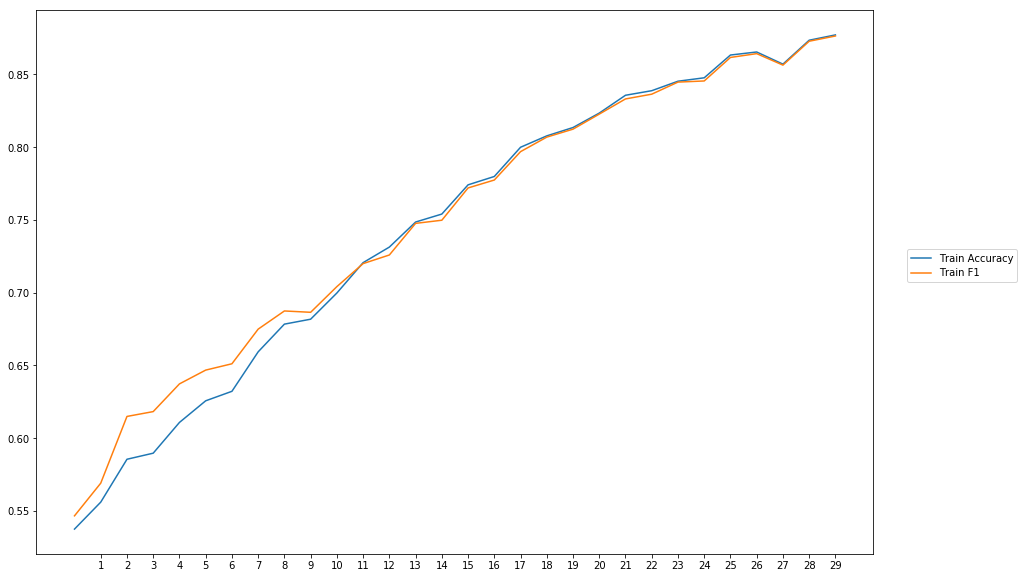


-----Test Scores----
Loss: 0.6740126159726357
Accuracy: 69.13265306122449
Precision: 62.36559137549621
Recall: 55.9485530366725
F1: 58.983045842172224


In [35]:
train_evaluate_three_inputs(model, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_senti_blob, train_pos, train_labels, test_data, test_senti_blob, test_pos, test_labels, softmax, outputpath, 'architecture')

## MLP after Wu simple

In [40]:
#Word Embeddings
wv_layer_2 = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix],
                 input_length=MAX_SEQUENCE_LENGTH,
                )# trainable=True

input_embedding_2 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedded_sequences_2 = wv_layer_2(input_embedding_2)
x_embedding_2 = Dropout(0.2)(embedded_sequences_2)

#Sentiment Features
input_sentiment_2 = Input(shape=(MAX_SEQUENCE_LENGTH,1), dtype='float')

#POS Features
input_pos_2 = Input(shape=(MAX_SEQUENCE_LENGTH,1), dtype='float')

#Concatination
concat_2 = concatenate([x_embedding_2, input_sentiment_2, input_pos_2], axis=-1)
x = Dense(600, activation='relu')(concat_2)
x = Flatten()(x)
preds_2 = Dense(2, activation='softmax')(x)

model_2 = Model(inputs=[input_embedding_2, input_sentiment_2, input_pos_2], outputs=preds_2)

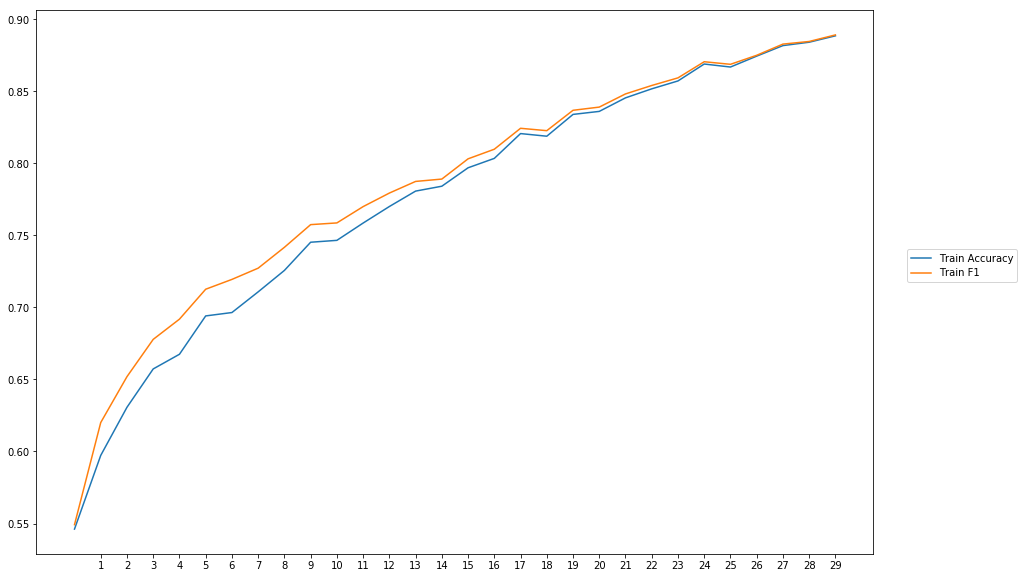


-----Test Scores----
Loss: 0.6114836821750719
Accuracy: 66.19897959183673
Precision: 56.05263156419667
Recall: 68.4887459586853
F1: 61.649777955311706


In [41]:
train_evaluate_three_inputs(model_2, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_senti_blob, train_pos, train_labels, test_data, test_senti_blob, test_pos, test_labels, softmax, outputpath, 'oldArchitecture')

## After Wu, seperate models

In [43]:
#Word Embeddings
wv_layer = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix],
                 input_length=MAX_SEQUENCE_LENGTH,
                 mask_zero = True) #trainable raus

input_embedding = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedded_sequences = wv_layer(input_embedding)
x_embedding = Dropout(0.2)(embedded_sequences)
gru_1_embedding = Bidirectional(GRU(300,return_sequences=True,dropout=0.2,recurrent_dropout=0.2))(x_embedding)
gru_2_embedding = Bidirectional(GRU(300,return_sequences=True,dropout=0.2,recurrent_dropout=0.2))(gru_1_embedding)
concat_embedding = concatenate([gru_1_embedding, gru_2_embedding])

gru_3_embedding = Bidirectional(GRU(300,return_sequences=False,dropout=0.4,recurrent_dropout=0.4))(concat_embedding)

#Sentiment Features
input_sentiment = Input(shape=(MAX_SEQUENCE_LENGTH,1), dtype='float')
gru_1_sentiment = Bidirectional(GRU(300,return_sequences=True,dropout=0.2,recurrent_dropout=0.2))(input_sentiment)
gru_2_sentiment = Bidirectional(GRU(300,return_sequences=True,dropout=0.2,recurrent_dropout=0.2))(gru_1_sentiment)
concat_sentiment = concatenate([gru_1_embedding, gru_2_sentiment])

gru_3_sentiment = Bidirectional(GRU(300,return_sequences=False,dropout=0.4,recurrent_dropout=0.4))(concat_sentiment)


#POS Features
input_pos = Input(shape=(MAX_SEQUENCE_LENGTH,1), dtype='float')
gru_1_pos = Bidirectional(GRU(300,return_sequences=True,dropout=0.2,recurrent_dropout=0.2))(input_pos)
gru_2_pos = Bidirectional(GRU(300,return_sequences=True,dropout=0.2,recurrent_dropout=0.2))(gru_1_pos)
concat_pos = concatenate([gru_1_embedding, gru_2_embedding])

gru_3_pos = Bidirectional(GRU(300,return_sequences=False,dropout=0.4,recurrent_dropout=0.4))(concat_pos)

#Concatenate the models
concat_3 = concatenate([gru_3_embedding, gru_3_sentiment, gru_3_pos])


x_3 = Dense(200,activation='relu')(concat_3)
preds_3 = Dense(2,activation='softmax')(x_3)

model_3 = Model(inputs=[input_embedding, input_sentiment, input_pos], outputs=preds_3)

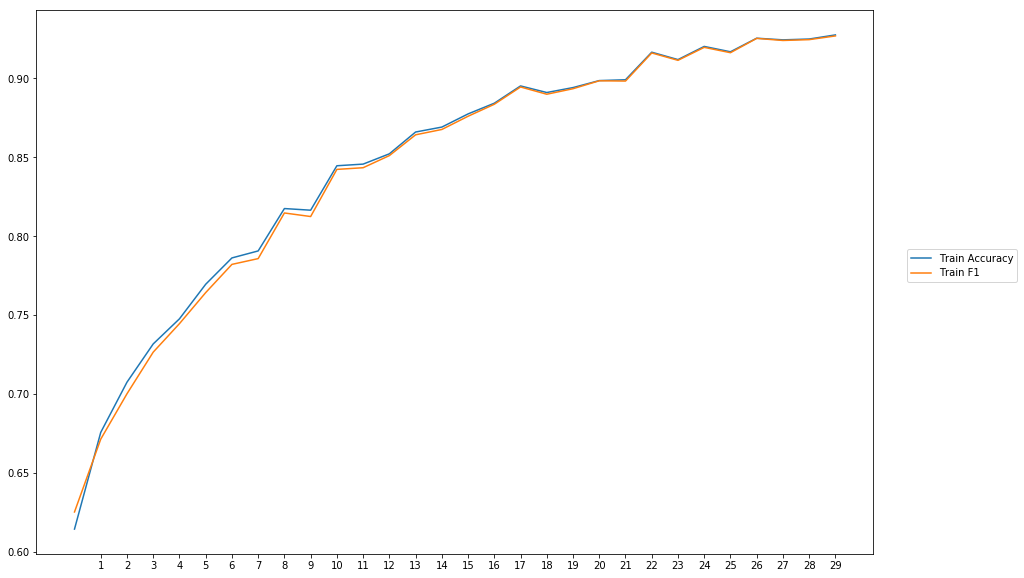


-----Test Scores----
Loss: 0.8873699441248056
Accuracy: 66.07142857142857
Precision: 55.72519082551523
Recall: 70.41800640822574
F1: 62.21590414106929


In [44]:
train_evaluate_three_inputs(model_3, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_senti_blob, train_pos, train_labels, test_data, test_senti_blob, test_pos, test_labels, softmax, outputpath, 'WuArchitecture_seperatmodels')

## Original MLP without flatten

In [53]:
#First part
wv_layer_mlp = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix],
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)

comment_input_mlp = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedded_sequences_mlp = wv_layer_mlp(comment_input_mlp)
x_first_mlp = Dense(600, activation='relu')(embedded_sequences_mlp)
#x_first_mlp = Flatten()(x_first_mlp)

#Second part
senti_input_mlp_blob = Input(shape=(MAX_SEQUENCE_LENGTH,1), dtype='float')
x_second_mlp = Dense(600, activation='relu')(senti_input_mlp_blob)

#Thrid part
senti_input_mlp_pos = Input(shape=(MAX_SEQUENCE_LENGTH,1), dtype='float')
x_third_mlp = Dense(600, activation='relu')(senti_input_mlp_pos)

#Concatination
concat_mlp = concatenate([x_first_mlp, x_second_mlp, x_third_mlp])
preds_mlp = Flatten()(concat_mlp)
preds_mlp = Dense(2, activation='softmax')(preds_mlp)

model_mlp = Model(inputs=[comment_input_mlp, senti_input_mlp_blob, senti_input_mlp_pos], outputs=preds_mlp)
model_mlp.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_67 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 40, 300)      4118700     input_67[0][0]                   
__________________________________________________________________________________________________
input_68 (InputLayer)           (None, 40, 1)        0                                            
__________________________________________________________________________________________________
input_69 (InputLayer)           (None, 40, 1)        0                                            
__________________________________________________________________________________________________
dense_31 (

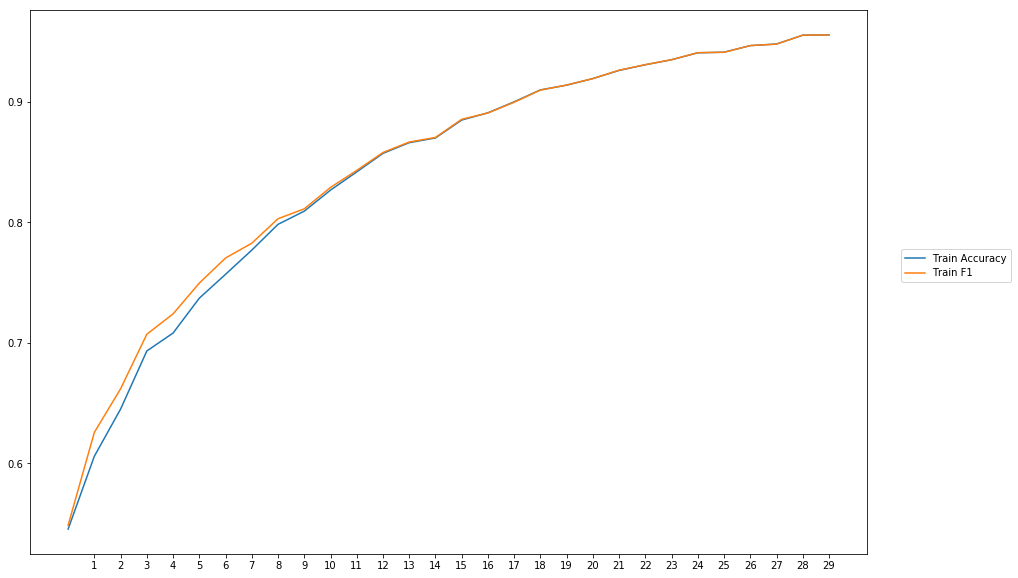


-----Test Scores----
Loss: 0.6099226870098893
Accuracy: 70.28061224489795
Precision: 60.051546376275375
Recall: 74.91961412382007
F1: 66.66666170826541


In [55]:
train_evaluate_three_inputs(model_mlp, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_senti_blob, train_pos, train_labels, test_data, test_senti_blob, test_pos, test_labels, softmax, outputpath, 'eigene_seperatmodels')

## Wu complex aditional GRU layers

In [13]:
#Word Embeddings
wv_layer_wu = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix],
                 input_length=MAX_SEQUENCE_LENGTH,
                 mask_zero = True) #trainable raus

input_embedding_wu = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedded_sequences_wu = wv_layer_wu(input_embedding_wu)
x_embedding_wu = Dropout(0.2)(embedded_sequences_wu)

#Sentiment Features
input_sentiment_wu = Input(shape=(MAX_SEQUENCE_LENGTH,1), dtype='float')

#POS Features
input_pos_wu = Input(shape=(MAX_SEQUENCE_LENGTH,1), dtype='float')

#Concatination
merge_input_wu=concatenate([x_embedding_wu,input_sentiment_wu,input_pos_wu], axis=-1)

#BiGRU
gru_1_wu = Bidirectional(GRU(300,return_sequences=True,dropout=0.2,recurrent_dropout=0.2))(merge_input_wu)
gru_2_wu = Bidirectional(GRU(300,return_sequences=True,dropout=0.2,recurrent_dropout=0.2))(gru_1_wu)

#Concatenation
concat_gu_wu = concatenate([gru_1_wu, gru_2_wu])

#BiGRU
gru_3_wu = Bidirectional(GRU(300,return_sequences=False,dropout=0.4,recurrent_dropout=0.4))(concat_gu_wu)

x_1_wu = Dense(200,activation='relu')(gru_3_wu)
x_2_wu = Dense(4,activation='softmax')(x_1_wu)

concat_dense_wu = concatenate([gru_3_wu, x_1_wu, x_2_wu])

x_3_wu = Dense(200,activation='relu')(concat_dense_wu)
x_4_wu = Dense(2, activation="softmax")(x_3_wu)

model_wu_complex = Model(inputs=[input_embedding_wu, input_sentiment_wu, input_pos_wu], outputs=x_4_wu)

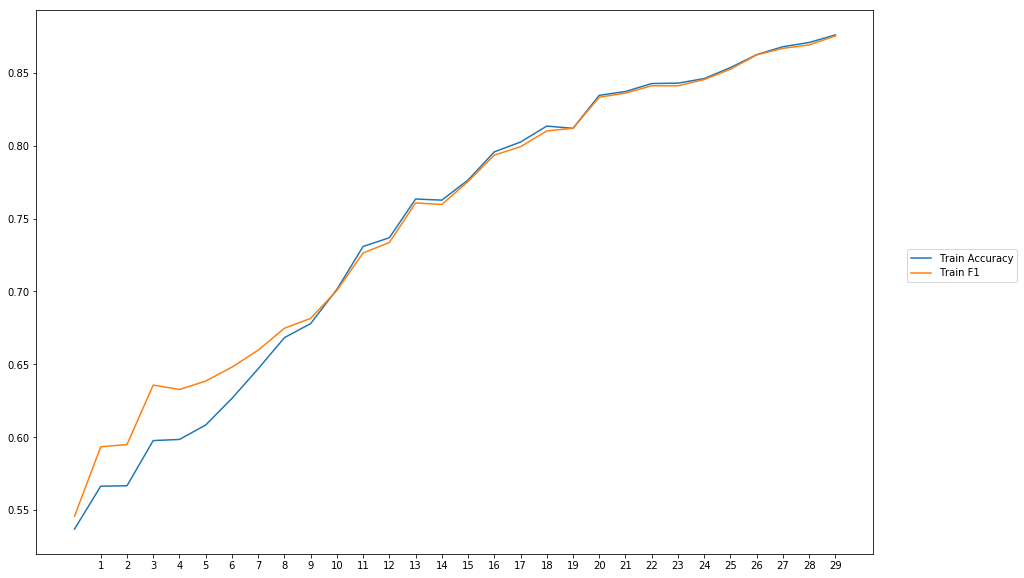


-----Test Scores----
Loss: 0.6374843376023429
Accuracy: 70.79081632653062
Precision: 61.84971096478332
Recall: 68.81028936694203
F1: 65.1445916458052


In [14]:
train_evaluate_three_inputs(model_wu_complex, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_senti_blob, train_pos, train_labels, test_data, test_senti_blob, test_pos, test_labels, softmax, outputpath, 'wu_complex')

## Wu komplex 

In [15]:
#Word Embeddings
wv_layer_wu_seperatmodels = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix],
                 input_length=MAX_SEQUENCE_LENGTH,
                 mask_zero = True) #trainable raus

input_embedding_wu_seperatmodels = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedded_sequences_wu_seperatmodels = wv_layer_wu_seperatmodels(input_embedding_wu_seperatmodels)
x_embedding_wu_seperatmodels = Dropout(0.2)(embedded_sequences_wu_seperatmodels)
gru_embeddings_wu_seperatmodels = Bidirectional(GRU(300,return_sequences=True,dropout=0.2,recurrent_dropout=0.2))(x_embedding_wu_seperatmodels)

#Sentiment Features
input_sentiment_wu_seperatmodels = Input(shape=(MAX_SEQUENCE_LENGTH,1), dtype='float')
gru_sentiment_wu_seperatmodels = Bidirectional(GRU(300,return_sequences=True,dropout=0.2,recurrent_dropout=0.2))(input_sentiment_wu_seperatmodels)

#POS Features
input_pos_wu_seperatmodels = Input(shape=(MAX_SEQUENCE_LENGTH,1), dtype='float')
gru_pos_wu_seperatmodels = Bidirectional(GRU(300,return_sequences=True,dropout=0.2,recurrent_dropout=0.2))(input_pos_wu_seperatmodels)

#Concatination
merge_input_wu_seperatmodels=concatenate([gru_embeddings_wu_seperatmodels,gru_sentiment_wu_seperatmodels,gru_pos_wu_seperatmodels], axis=-1)

#BiGRU
gru_1_wu_seperatmodels = Bidirectional(GRU(300,return_sequences=True,dropout=0.2,recurrent_dropout=0.2))(merge_input_wu_seperatmodels)
gru_2_wu_seperatmodels = Bidirectional(GRU(300,return_sequences=True,dropout=0.2,recurrent_dropout=0.2))(gru_1_wu_seperatmodels)

#Concatenation
concat_gu_wu_seperatmodels = concatenate([gru_1_wu_seperatmodels, gru_2_wu_seperatmodels])

#BiGRU
gru_3_wu_seperatmodels = Bidirectional(GRU(300,return_sequences=False,dropout=0.4,recurrent_dropout=0.4))(concat_gu_wu_seperatmodels)

x_1_wu_seperatmodels = Dense(200,activation='relu')(gru_3_wu_seperatmodels)
x_2_wu_seperatmodels = Dense(4,activation='softmax')(x_1_wu_seperatmodels)

concat_dense_wu_seperatmodels = concatenate([gru_3_wu_seperatmodels, x_1_wu_seperatmodels, x_2_wu_seperatmodels])

x_3_wu_seperatmodels = Dense(200,activation='relu')(concat_dense_wu_seperatmodels)
x_4_wu_seperatmodels = Dense(2, activation="softmax")(x_3_wu_seperatmodels)

model_wu_seperatmodels_complex = Model(inputs=[input_embedding_wu_seperatmodels, input_sentiment_wu_seperatmodels, input_pos_wu_seperatmodels], outputs=x_4_wu_seperatmodels)

In [ ]:
train_evaluate_three_inputs(model_wu_seperatmodels_complex, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_senti_blob, train_pos, train_labels, test_data, test_senti_blob, test_pos, test_labels, softmax, outputpath, 'wu_complex_aditionalgru')